## Imports

In [1]:
# basic ml imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from warnings import filterwarnings

# applying beatuful styling 
import seaborn as sns
sns.set()
# to ignore warnings when using Grid Search
filterwarnings(action='ignore',
               message=".*Setting penalty='none' will ignore the C and l1_ratio parameters.*")
# debugging tool
from IPython.core.debugger import set_trace
# my tools module
import tools


In [2]:
# debugging fragment
from importlib import reload
reload(tools)

<module 'tools' from '/home/vsevolod/Documents/python_stuff/kaggel-titanic-competition/tools.py'>

## Data cleaning

In [3]:
df_all = pd.read_csv('data/train.csv')
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
# print count of na values.
column_wise_nans = df_all.isna().sum(0)
percent_of_nans = column_wise_nans / df_all.shape[0] * 100
print(f'Percent of nans in columns: \n\n{percent_of_nans}')

Percent of nans in columns: 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [5]:
# dropping useless labels
df_all.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'],axis=1, inplace=True)

# working with na
df_all.dropna(inplace=True)
# using one hot encoding for categorical data
df_all = pd.get_dummies(df_all, columns=['Sex', 'Embarked'])

df_all.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


Split data on training/test

In [6]:
df_X = df_all.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_all['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


## Training stupid logistic regression

Split data on training/test

In [7]:
df_X = df_all.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_all['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


score: 0.8157894736842105
best params: {'estimator__C': 0.01, 'estimator__fit_intercept': True}


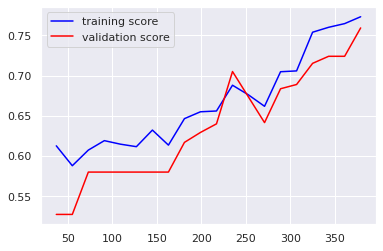

In [8]:
model_all_features = tools.train_estimator_via_grid(X_train, y_train)[0]


In [9]:
tools.get_coefs_of_regression(model_all_features['estimator'], df_X)

Pclass       -0.252230
Age          -0.033948
SibSp        -0.012416
Parch         0.013106
Fare          0.048926
Sex_female    0.364634
Sex_male     -0.364634
Embarked_C    0.103071
Embarked_Q   -0.024470
Embarked_S   -0.078601
dtype: float64

## Trying add/delete new features to increase performance of logistic regression

In [10]:
def display_estimator_result(X_train, y_train, C=0.01):
    model = Pipeline([('data_transformer', MinMaxScaler()),
                      ('estimator', LogisticRegression(C=C, fit_intercept=False))])
    cv_result = cross_validate(model, X_train, y_train, cv=5)
    tools.plot_learning_curves(model, X_train, y_train)
    print(cv_result['test_score'])
    return model.fit(X_train, y_train)

## Let's combine two estimators

In this section I want to implement estimator that will combine results of prediction based only on "Sex" parameter and on prediction based on other parameters

score: 0.7132867132867133
best params: {'estimator__C': 1, 'estimator__fit_intercept': True}


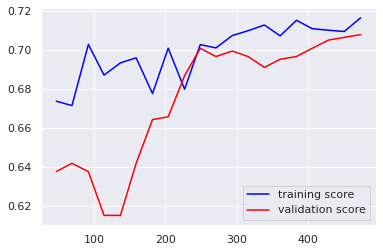

In [11]:
model_without_sex, X_test_without_sex, y_test_without_sex = tools.train_estimator_via_grid(tools.drop_df_columns(df_X, ['Sex_female', 'Sex_male']), y)

score: 0.7762237762237763
best params: {'estimator__C': 0.001, 'estimator__fit_intercept': False}


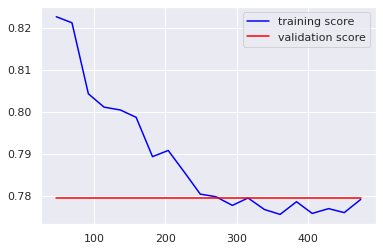

In [12]:
model_with_sex, X_train_with_sex, y_train_with_sex = tools.train_estimator_via_grid(df_X[['Sex_male', 'Sex_female']], y)

### Хочу понять совершают ли предсказатели ошибки систематически или только когда не уверены в ответе?

Классификатор по полу крайне неуверен в своих ответах

In [13]:
model_with_sex.predict_proba(np.array([[0, 1], [1, 0]]))

array([[0.48857876, 0.51142124],
       [0.52551209, 0.47448791]])

Классификатор без пола ведет себя более интресно(что очевидно)

In [14]:
prob = pd.DataFrame(model_without_sex.predict_proba(X_test_without_sex))
prob['prediction_true'] = y_test_without_sex == np.argmax(prob.to_numpy(), axis=1)
prob.head()

,0,1,prediction_true
0,0.664264,0.335736,False
1,0.739718,0.260282,True
2,0.776180,0.223820,False
3,0.807536,0.192464,True
4,0.769946,0.230054,False


In [15]:
def find_error_in_prob_range(df, low, up):
    deviation = np.abs(df.iloc[:, 0] - 0.5)
    delta_deviation_mask = ((low < deviation) &
                            (up > deviation))
    mask_size = np.sum(delta_deviation_mask)
    prediction_results = prob.loc[delta_deviation_mask, 'prediction_true']
    return np.sum(prediction_results) / mask_size, mask_size

In [16]:
results = []
for low in np.linspace(0, 0.4, 5):
    low = round(low, 1)
    up = round(low + 0.1, 1)
    err = np.round(find_error_in_prob_range(prob, low, up), 3)
    results.append([low, up, *err])
pd.DataFrame(results)

<ipython-input-15-c7117977ed1a>:7: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(prediction_results) / mask_size, mask_size


,0,1,2,3
0,0.0,0.1,0.577,26.0
1,0.1,0.2,0.706,34.0
2,0.2,0.3,0.724,58.0
3,0.3,0.4,0.840,25.0
4,0.4,0.5,NaN,0.0


## Playing with penalty

In [18]:
def playing_with_penalty(C=1, penalty='l2'):
    model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(penalty=penalty, C=C))])
    tools.plot_learning_curves(model, X, y)
    model.fit(X, y)
    return tools.get_coefs_of_regression(model['estimator'], df_X)

Pclass       -2.398508
Age          -3.449790
SibSp        -1.816012
Parch        -0.361639
Fare          0.733461
Sex_female    2.053544
Sex_male     -0.584941
Embarked_C    0.897811
Embarked_Q    0.074209
Embarked_S    0.496582
dtype: float64

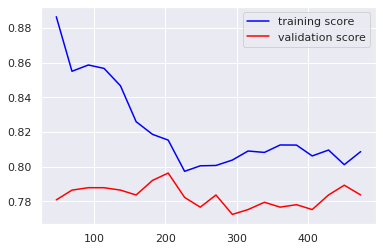

In [19]:
# small penalty
playing_with_penalty(C=1e6)

Pclass       -2.393811
Age          -3.430685
SibSp        -1.803842
Parch        -0.360502
Fare          0.725396
Sex_female    1.320790
Sex_male     -1.315619
Embarked_C    0.410035
Embarked_Q   -0.412723
Embarked_S    0.007858
dtype: float64

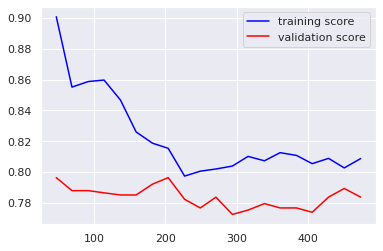

In [20]:
playing_with_penalty(C=1e2)

Pclass       -2.063324
Age          -2.259569
SibSp        -1.117715
Parch        -0.263937
Fare          0.423856
Sex_female    1.250759
Sex_male     -1.251334
Embarked_C    0.401858
Embarked_Q   -0.352032
Embarked_S   -0.050401
dtype: float64

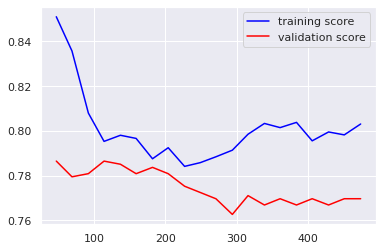

In [21]:
# bigger penalty
playing_with_penalty(C=1)

Pclass       -1.525622
Age          -0.947809
SibSp        -0.451387
Parch        -0.102234
Fare          0.255880
Sex_female    1.129621
Sex_male     -1.129637
Embarked_C    0.364831
Embarked_Q   -0.242163
Embarked_S   -0.122685
dtype: float64

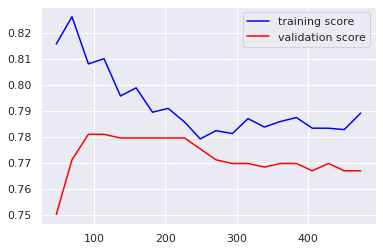

In [22]:
playing_with_penalty(C=0.2)

Pclass       -0.352486
Age          -0.052472
SibSp        -0.021975
Parch         0.019217
Fare          0.061180
Sex_female    0.489238
Sex_male     -0.489239
Embarked_C    0.143369
Embarked_Q   -0.032840
Embarked_S   -0.110530
dtype: float64

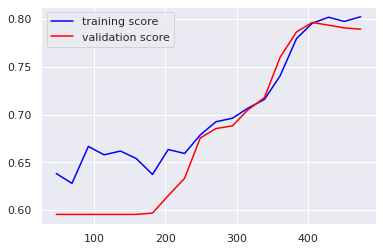

In [23]:
# really strong penalty
playing_with_penalty(C=0.01)

### Covariance matrix

In [12]:
covariance = df_all.cov()

covariance.style.background_gradient(cmap='coolwarm').format(precision=2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,0.24,-0.15,-0.59,-0.01,0.04,6.92,0.13,-0.13,0.04,-0.00,-0.03
Pclass,-0.15,0.70,-4.44,0.05,0.02,-24.49,-0.06,0.06,-0.09,0.02,0.07
Age,-0.59,-4.44,210.05,-4.15,-2.33,71.46,-0.69,0.69,0.21,-0.06,-0.15
SibSp,-0.01,0.05,-4.15,0.87,0.30,6.89,0.05,-0.05,-0.02,0.01,0.01
Parch,0.04,0.02,-2.33,0.30,0.73,9.34,0.10,-0.10,-0.00,-0.00,0.00
Fare,6.92,-24.49,71.46,6.89,9.34,2802.50,4.65,-4.65,6.17,-0.64,-5.53
Sex_female,0.13,-0.06,-0.69,0.05,0.10,4.65,0.23,-0.23,0.02,0.00,-0.02
Sex_male,-0.13,0.06,0.69,-0.05,-0.10,-4.65,-0.23,0.23,-0.02,-0.00,0.02
Embarked_C,0.04,-0.09,0.21,-0.02,-0.00,6.17,0.02,-0.02,0.15,-0.01,-0.14
Embarked_Q,-0.00,0.02,-0.06,0.01,-0.00,-0.64,0.00,-0.00,-0.01,0.04,-0.03


## Trying to visualize different features

/home/vsevolod/anaconda3/envs/main/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<AxesSubplot:title={'center':'survived_perc'}>,
       <AxesSubplot:title={'center':'perc_of_all'}>], dtype=object)

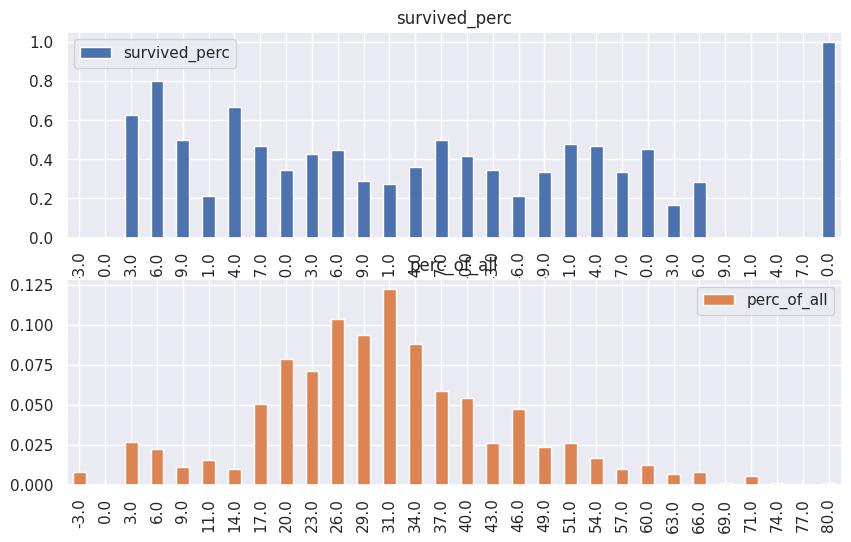

In [106]:
def continious_data_to_bins(column, bins_number):
    df_with_categorical_age, bins_arr = pd.cut(df_all[column], bins_number, retbins=True )
    groupby_age =  df_all.groupby(df_with_categorical_age)
    df_age = groupby_age['Survived'].agg(['mean', 'count'])
    df_age.set_index(np.round(bins_arr[1:]), inplace=True)
    df_age['count'] = df_age['count'] / df_all.shape[0]
    df_age.rename(columns={'mean': 'survived_perc',  'count': 'perc_of_all'}, inplace=True)
    return df_age

df_age = continious_data_to_bins('Age', 30)

df_for_plot = df_age
fig, axes = plt.subplots(2, dpi=100, figsize=(10, 6), sharex='')
df_age.plot.bar(ax=plt.gca(), subplots=True)


## Fooling around with deep learning

Epoch 1/10
3/3 [==============================] - 2s 187ms/step - loss: 0.3249 - accuracy: 0.6040 - val_loss: 0.2469 - val_accuracy: 0.68
Epoch 2/10
3/3 [==============================] - 0s 77ms/step - loss: 0.2607 - accuracy: 0.6743 - val_loss: 0.5029 - val_accuracy: 0.412
Epoch 3/10
3/3 [==============================] - 0s 55ms/step - loss: 0.3990 - accuracy: 0.5217 - val_loss: 0.2462 - val_accuracy: 0.696
Epoch 4/10
3/3 [==============================] - 0s 74ms/step - loss: 0.2442 - accuracy: 0.6951 - val_loss: 0.3527 - val_accuracy: 0.595
Epoch 5/10
3/3 [==============================] - 0s 81ms/step - loss: 0.3022 - accuracy: 0.6479 - val_loss: 0.2519 - val_accuracy: 0.688
Epoch 6/10
3/3 [==============================] - 0s 62ms/step - loss: 0.2390 - accuracy: 0.6898 - val_loss: 0.3606 - val_accuracy: 0.589
Epoch 7/10
3/3 [==============================] - 0s 57ms/step - loss: 0.2507 - accuracy: 0.6979 - val_loss: 0.2589 - val_accuracy: 0.598
Epoch 8/10
3/3 [==================

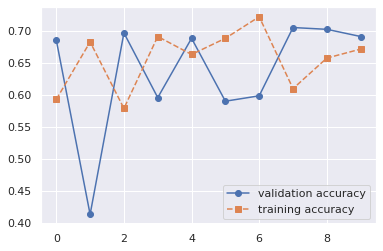

In [95]:
# my stupid and random try to deep learning without knowing anything
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_shape=(10, )))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])


titanic_recognition_model = model.fit(X_train, y_train,
              batch_size=128,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True)

plt.plot(titanic_recognition_model.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(titanic_recognition_model.history['accuracy'], '--s', label='training accuracy')
plt.legend();
